# Pan Temperature Distribution Model

See the [paper](../paper/pans.pdf) for the derivation of the model, discretization, and formation of the linear system that is solved here.

## Solution of the reduced physical model

The reduced model is solved by nondimensionalizing, discretizing, forming a linear system, and then finding its solution by a sparse linear system solver.

In [70]:
from typing import Callable
import numpy as np
from scipy.sparse import diags_array, block_array
from scipy.sparse.linalg import spsolve

def pan_model(
        r_pan : float,
        z_pan : float,
        k : float,
        h : float,
        T_exterior : float,
        T_burner : Callable[[float],float],
        n : int,
        m : int
    ) -> tuple[np.ndarray]:
    """Solves for the steady-state temperature distribution in a pan

    Given the physical properties of a pan and its base's temperature
    distribution due to a burner, solves a model of heat transfer to
    find the steady-state temperature distribution of the pan. Performs
    a nondimensionalization of the input parameters, discretization
    into an n+1 by m+1 grid, formation of a linear system, and finally 
    a sparse linear solve.
    
    Args:
        r_pan (float): radius of the pan in meters
        z_pan (float): thickness of the pan in meters
        k (float): thermal conductivity of the pan in 
            Watts per meter Kelvin
        h (float): heat transfer coefficient of the pan in 
            Watts per meter^2 Kelvin
        T_exterior (float): temperature on the sides and top of the pan
        T_burner (Function(float) -> float): pan base temperature as a
            function of radius
        n (int): grid points in the r direction
        m (int): grid points in the z direction
    
    Returns:
        (R, Z, T) - the tuple of 3 np.ndarrays containing the grid point
        locations in r, z, and the steady-state temperature at each point.
    """
    # Step 1: Nondimensionalization
    # Scalings
    r_scale = r_pan
    z_scale = z_pan
    T_scale = T_exterior

    # Apply Scalings
    T_hat_burner = lambda r: T_burner(r_scale * r) / T_scale
    T_hat = T_exterior / T_scale

    # Dimensionless Parameters
    beta = -k / (h*z_scale)
    alpha = r_scale / z_scale


    # Step 2: Discretization
    # r, z on [0, 1] x [0, 1] - the interior r and z values
    d_r = 1/n
    d_z = 1/m
    r = np.linspace(0, 1, n)
    z = np.linspace(0, 1, m)

    # T with ghost points - the pan starts at room temp
    T_0 = np.ones(n*m) * T_hat

    # Discretized bottom temperature distribution
    T_b = np.array([T_hat_burner(ri) for ri in r])
    

    # Step 3: Forming Sparse Linear System
    I_n = diags_array(np.ones(n), format="csr")

    # Radial Derivatives as matrices
    D_rr = (1 / d_r**2) * diags_array([1, -2, 1], offsets=[-1, 0, 1], 
                            shape=(n,n), format="csr")
    D_r = (1 / (2*d_r)) * diags_array([-1, 0, 1], offsets=[-1, 0, 1],
                            shape=(n,n), format="csr")
    
    # diag(1/r)
    # At r=0, the boundary condition forces (partial of T in r)=0
    #    so (partial of T in r)/r -> 0 at r=0 means we can ignore the
    #    first component of r[i] if it is zero before inverting.
    r_copy = np.copy(r)
    if (r[0] == 0):
        r_copy[0] = 1
    diag_inverse_r = diags_array((1/r_copy), offsets=0,
                    shape=(n,n), format="csr")
    
    # Z Derivatives
    D_zz_in = (-2 * alpha**2 / d_z**2) * I_n
    D_zz_pm = (alpha**2 / d_z**2) * I_n

    # Forcing
    f = np.zeros(n)
    
    # Impose Boundary conditions
    # Inner boundary
    D_rr[0,0] = -1 / d_r**2
    D_r[0,1] = 0

    # Outer boundary
    D_rr[-1,-1] = ((alpha*d_r / beta) - 1) / d_r**2
    D_r[-1,-2] = 0
    D_r[-1,-1] = alpha / (beta*r[-1])
    f[-1] = (1/d_r + 1/r[-1]) * (alpha / beta) * T_b[-1]

    # Top boundary
    # Use these blocks when creating the top row instead
    D_zz_bc = (alpha**2 / d_z**2)*(-1+d_z/beta) * I_n
    f_top = f + (alpha**2 / (d_z*beta)) * T_hat

    # Bottom boundary
    # Use D_zz_bc for bottom row as well
    f_bot = f + (alpha**2 / (d_z*beta)) * T_b
    
    # Entire System
    # interior row main diagonal
    L_in = D_rr + diag_inverse_r @ D_r + D_zz_in
    L_bc = D_rr + diag_inverse_r @ D_r + D_zz_bc

    # List of blocks
    blocks = []
    for j in range(m):
        if (j == 0):
            blocks.append([L_bc, D_zz_pm] + [None]*(m-2))
        elif (j == m-1):
            blocks.append([None]*(m-2) + [D_zz_pm, L_bc])
        else:
            blocks.append([None]*(j-1) + [D_zz_pm, L_in, D_zz_pm] + [None]*(m-j-2))
    A = block_array(blocks, format="csr")
    b = np.concatenate((f_bot, np.tile(f,m-2), f_top))


    # Step 4: Solving the linear system
    T = spsolve(A, b)


    # Step 5: Prepare Output
    R, Z = np.meshgrid(r*r_scale, z*z_scale)
    T_steady_state = T.reshape(m,n)*T_scale

    return (R, Z, T_steady_state)

## Physical Model Parameters

The physical properties of a frying pan are required to solve a realistic model. Those values are defined below:

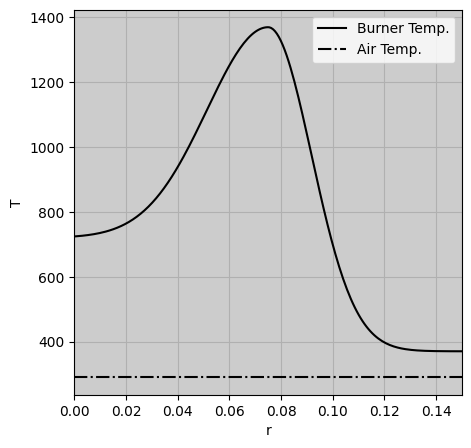

In [71]:
import matplotlib.pyplot as plt

# Frying pan properties
r_p = 0.15          # [m]
z_p = 0.005         # [m]
k_cast_iron = 40.0  # [W / m K]
h_cast_iron = 20.0  # [W / m^2 K]

# Temperatures
T_air = 290.0  # [K]
def T_b_distribution(r : float, r_b : float, r_p : float) -> float:
    """Burner Radial Temperature Distribution

    Gives the temperature at the bottom of a pan from a burner of 
    radius r_b at radius r for a pan of radius r_p.

    Args:
        r (float): radius to get temperature at
        r_b (float): burner radius
        r_p (float): pan radius
    
    Returns:
        the temperature at radius r due to a burner of size r_b
    """
    normal_dist = lambda r, mu, var: np.exp(-(r-mu)**2 / var)
    T_central = 970.0 - 500.0 * (r_b/r_p)
    T_fire = 1370.0
    T_ext = 290.0 + 80.0
    if r < r_b:
        return T_central + (T_fire-T_central)*normal_dist(r/r_b, 1, 2e-1)
    else:
        return T_ext + (T_fire-T_ext)*normal_dist(r/r_b, 1, 1e-1)

r = np.linspace(0,r_p,200)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.plot(r, [T_b_distribution(ri, 0.5*r_p, r_p) for ri in r], '-k', label='Burner Temp.')
ax.plot([0,r_p],[T_air,T_air], '-.k', label='Air Temp.')
ax.set_xlabel('r'), ax.set_ylabel('T')
ax.legend(loc='best')
ax.grid()
ax.set_facecolor((0.8,0.8,0.8))
ax.set_xmargin(0)
plt.show()



## Finding the steady-state temperature distribution

The model was solved using the burner temperature distribution described above.

In [72]:
N = 2**7

R, Z, T = pan_model(r_p, z_p, k_cast_iron, h_cast_iron, T_air, 
					T_burner = lambda r: T_b_distribution(r, 0.4*r_p, r_p),
                    n = N, m = N//4)

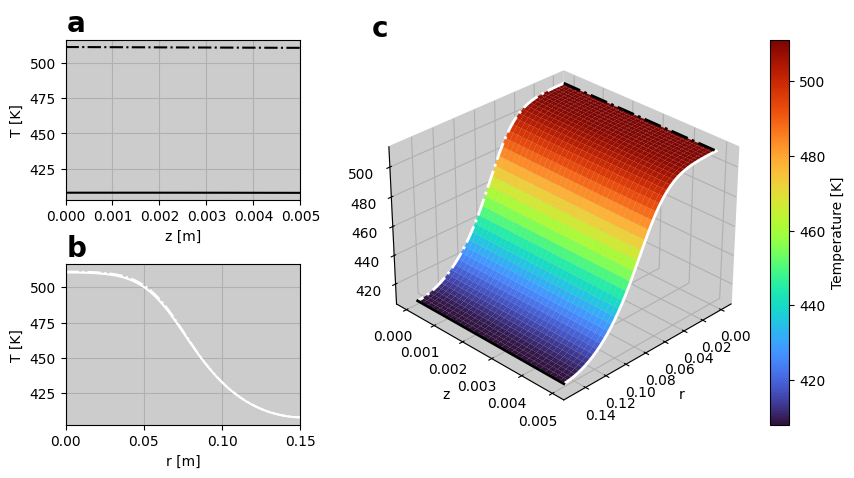

In [74]:
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

plot_bg_color = (0.8, 0.8, 0.8)

fig = plt.figure(figsize=(10,5))
gs = GridSpec(2, 2, width_ratios=[1, 2], hspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.plot(Z[:,0], T[:,0], '-.k')
ax.plot(Z[:,0], T[:,-1], '-k')
ax.set_xlabel('z [m]'), ax.set_ylabel('T [K]')
ax.grid()
ax.set_facecolor(plot_bg_color)
ax.set_xmargin(0)
ax.set_title('$\\bf a$', loc='left', fontsize=20)


ax = fig.add_subplot(gs[1, 0])
ax.plot(R[0], T[0], '-.w')
ax.plot(R[0], T[-1], '-w')
ax.set_xlabel('r [m]'), ax.set_ylabel('T [K]')
ax.grid()
ax.set_facecolor(plot_bg_color)
ax.set_xmargin(0)
ax.set_title('$\\bf b$', loc='left', fontsize=20)


ax = fig.add_subplot(gs[:, 1], projection='3d')
surf = ax.plot_surface(R, Z, T, cmap=cm.turbo)
fig.colorbar(surf, label='Temperature [K]')
ax.view_init(30, 45, 0)
ax.set_xlabel('r'), ax.set_ylabel('z')
ax.plot(R[0], T[0], '-.w', zs=0, zdir='y', zorder=3, linewidth=2)
ax.plot(R[0], T[-1], '-w', zs=z_p, zdir='y', zorder=3, linewidth=2)
ax.plot(Z[:,0], T[:,0], '-.k', zs=0, zdir='x', zorder=3, linewidth=2)
ax.plot(Z[:,0], T[:,-1], '-k', zs=r_p, zdir='x', zorder=3, linewidth=2)
ax.xaxis.set_pane_color(plot_bg_color)
ax.yaxis.set_pane_color(plot_bg_color)
ax.zaxis.set_pane_color(plot_bg_color)
ax.set_title('$\\bf c$', loc='left', fontsize=20)

plt.show()

## Pan Surface Temperature Distribution for many Burner Radii

The effect of different burner sizes are compared for a 15cm radius, 0.5cm thick, cast iron pan

In [75]:
r_p = 0.15
z_p = 0.005
k_cast_iron = 40.0
h_cast_iron = 20.0

N_radii = 100
burner_radii = np.linspace(r_p/N_radii, r_p, N_radii)
data = []

n = 128
for r_b in burner_radii:
	R, _, T = pan_model(r_p, z_p, k_cast_iron, h_cast_iron, T_air,
					 lambda r: T_b_distribution(r, r_b, r_p),
					 n = n, m = n//16)
	# grab only the pan surface temperature distribution in C
	data.append(T[-1])

# convert R to fraction of r_p
R /= r_p

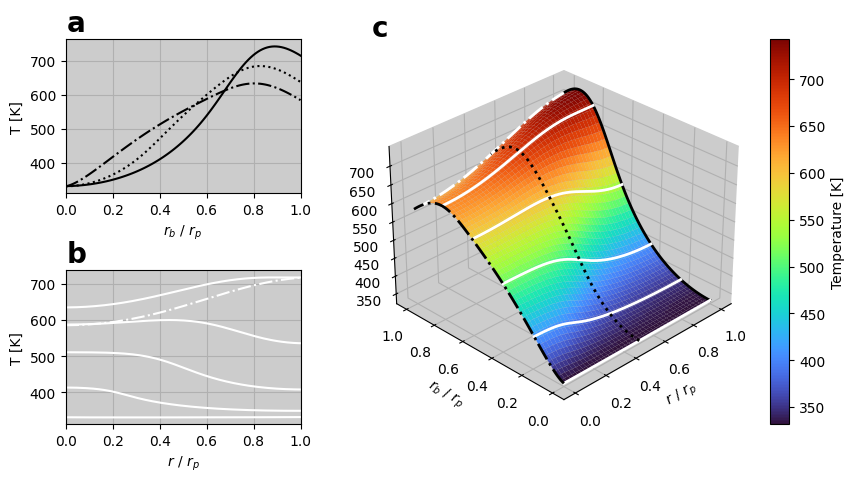

In [76]:
r_b_lines = 6
indices = [int(N_radii*p) for p in np.linspace(0, 0.99, r_b_lines)]


fig = plt.figure(figsize=(10,5))
gs = GridSpec(2, 2, width_ratios=[1, 2], hspace=0.5)


ax = fig.add_subplot(gs[1,0])
for count, i in enumerate(indices):
	if count < 3*len(indices)/4:
		ax.plot(R[0], data[i], '-w')
	else:
		ax.plot(R[0], data[i], '-.w')
ax.set_xlabel('$r\\ /\\ r_p$'), ax.set_ylabel('T [K]')
ax.set_facecolor(plot_bg_color)
ax.set_xmargin(0)
ax.grid()
ax.set_title('$\\bf b$', loc='left', fontsize=20)


ax = fig.add_subplot(gs[:,1], projection='3d')
r_b_over_r_p = np.linspace(0, 1, N_radii)
R_grid, N_grid = np.meshgrid(R[0], r_b_over_r_p)
surf = ax.plot_surface(R_grid, N_grid, np.array(data), cmap=cm.turbo, )
ax.plot(N_grid[:,0], [Temps[-1] for Temps in data], '-k', zs=1, zdir='x', zorder=3, linewidth=2)
for count, i in enumerate(indices):
	if count < 3*len(indices)/4:
		ax.plot(R[0], data[i], '-w', zs=r_b_over_r_p[i], zdir='y', zorder=3, linewidth=2)
	else:
		ax.plot(R[0], data[i], '-.w', zs=r_b_over_r_p[i], zdir='y', zorder=3, linewidth=2)
ax.plot(N_grid[:,0], [Temps[n//2] for Temps in data], ':k', zs=0.5, zdir='x', zorder=3, linewidth=2)
ax.plot(N_grid[:,0], [Temps[0] for Temps in data], '-.k', zs=0, zdir='x', zorder=3, linewidth=2)
ax.set_xlabel('$r\\ /\\ r_p$'), ax.set_ylabel('$r_b\\ /\\ r_p$')
fig.colorbar(surf, label="Temperature [K]")
ax.view_init(30, -135, 0)
ax.xaxis.set_pane_color(plot_bg_color)
ax.yaxis.set_pane_color(plot_bg_color)
ax.zaxis.set_pane_color(plot_bg_color)
ax.set_title('$\\bf c$', loc='left', fontsize=20)


ax = fig.add_subplot(gs[0,0])
ax.plot(N_grid[:,0], [Temps[0] for Temps in data], '-.k')
ax.plot(N_grid[:,0], [Temps[n//2] for Temps in data], ':k')
ax.plot(N_grid[:,0], [Temps[-1] for Temps in data], '-k')
ax.set_xlabel('$r_b\\ /\\ r_p$'), ax.set_ylabel('T [K]')
ax.grid()
ax.set_facecolor(plot_bg_color)
ax.set_xmargin(0)
ax.set_title('$\\bf a$', loc='left', fontsize=20)

plt.show()